# 01: Exploratory Time Series Analysis

Index:
- Structural assessment of time series (ruptures package)
    - Analysis and segmentation of non-stationary signals. Implemented algorithms include exact and approximate detection for various parametric and non-parametric models
    - The purpose is to find points in space (if they exist) where the structure of the signal breaks and assumes a different behavior usually due to an exogenous variable
- Visualize Moving Average and Autoregressive Components
- Visualize the behavior of the time series with dispersion and distribution analysis across days of the week and months of the year

In [1]:
import pandas as pd
from skforecast.datasets import fetch_dataset
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import numpy as np
import ruptures as rpt
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

data = fetch_dataset('bike_sharing', raw=True)
data = data[['date_time', 'users']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data.head()

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


,users
date_time,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0


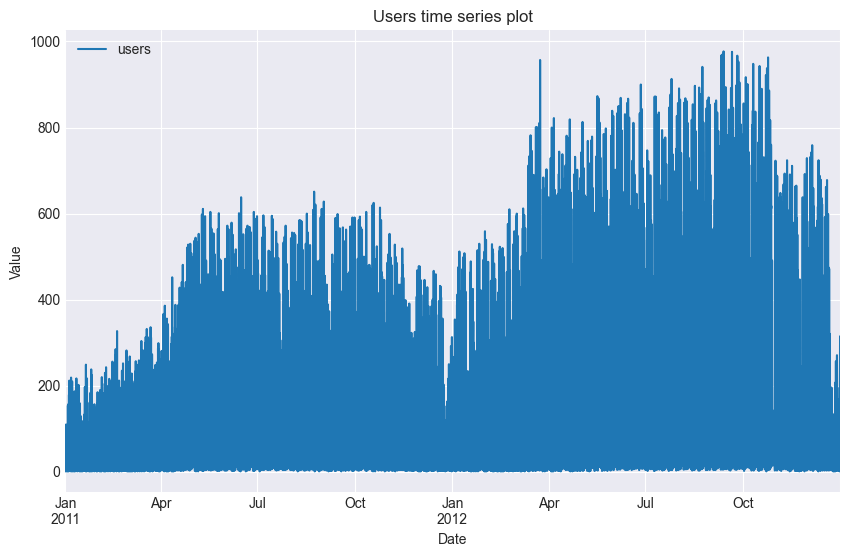

In [2]:
data[["users"]].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Users time series plot')
plt.grid(True)

### Moving average (365 days)

<Axes: title={'center': 'Bike Users - 365-Day Moving Average'}, xlabel='date_time'>

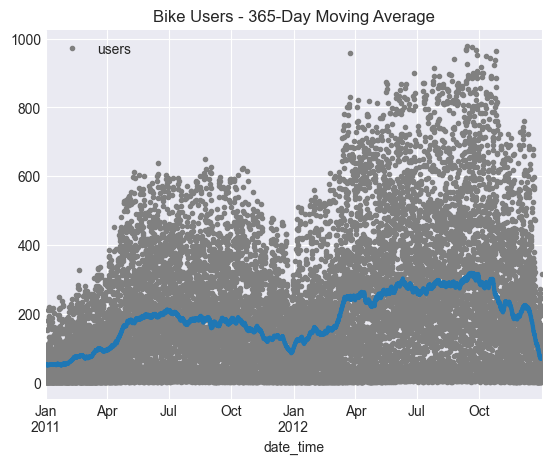

In [3]:
moving_average = data[["users"]].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=180,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = data.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Bike Users - 365-Day Moving Average", legend=False,
)

In [4]:
# Model Inputs
points = np.array(data["users"])

# Define and fit model (window with 90 width and l2 loss)
algo = rpt.Window(width=30, model="l2").fit(data["users"])

# Predict breakpoints - either manually or via penalization factor (this example)
breakpoints = algo.predict(pen=np.log(len(points)) * 2 * np.var(points)/2) # just an example, see docs for more information.

# Defining number of break points manually is also possible
# breakpoints = algo.predict(n_bkps=10) # or define number of break points manually

# Display results
rpt.show.display(points, breakpoints, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search With Penalty Factor')

AttributeError: 'Series' object has no attribute 'reshape'

### Seasonality plots

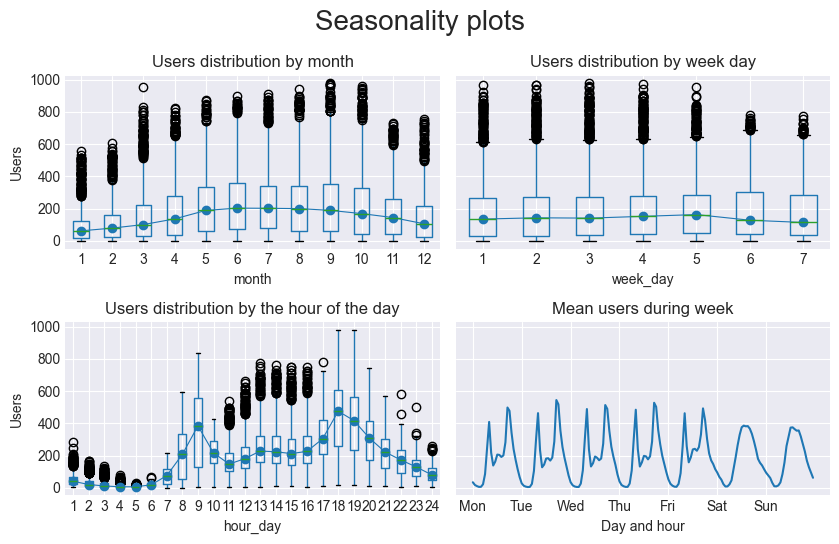

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 5.5), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
data['month'] = data.index.month
data.boxplot(column='users', by='month', ax=axs[0])
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month')

# Users distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='users', by='week_day', ax=axs[1])
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day')

# Users distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='users', by='hour_day', ax=axs[2])
data.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day')

# Users distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)

fig.suptitle("Seasonality plots", fontsize=20)
fig.tight_layout()